# 1 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from matplotlib import pyplot as plt
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集.我们使用线性模型参数w = [2,-3.4]T, b = 4.2和噪声项c(中间有横线)生成数据集及其标签:

y = Xw + b + c

In [2]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`feature`中的每一行都包含一个二维数据样本,`labels`中的每一行都包含一维标签值(一个标量)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.8454,  1.4985]) 
label: tensor([-2.5756])


'在pytorch的版本中需要把数据detach()出来才能转入numpy中'

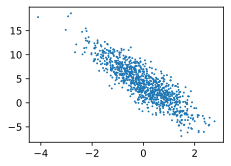

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
           labels.detach().numpy(), 1);
"""在pytorch的版本中需要把数据detach()出来才能转入numpy中"""

定义一个`data_iter`函数,该函数接收批量,特征矩阵和标签向量作为输入,生成大小为`batch_size`的小批量

In [5]:
"""读取函数批量参数"""
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的,没有特定顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        """yield为python的一个iteration不断调用返回"""
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.8313,  1.1799],
        [ 1.0721, -1.6605],
        [ 1.4501, -0.4973],
        [ 0.3324, -0.6443],
        [ 0.4252, -1.6987],
        [ 0.9220,  0.0368],
        [ 0.1946, -0.7618],
        [ 1.1026, -0.0342],
        [-1.3899,  0.5238],
        [ 0.6089, -0.2761]]) 
 tensor([[ 1.8427],
        [11.9960],
        [ 8.8105],
        [ 7.0656],
        [10.8173],
        [ 5.9083],
        [ 7.1777],
        [ 6.5362],
        [-0.3694],
        [ 6.3542]])


#### 定义初始化模型参数

In [20]:
w = torch.normal(0, 0.01, size = (2, 1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

#### 定义模型

In [21]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 定义损失函数

In [22]:
def squared_loss(y_hat, y):
    """y_hat预测值,y实际值"""
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

#### 定义优化算法

In [23]:
def sgd(params, lr, batch_size):
    """参数, 学习率, 批量"""
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            """手动梯度清零,防止下次梯度重复"""

#### 训练过程

In [24]:
lr = 0.01
num_epochs = 10
"""整个数据跑3遍"""
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        """X 和 y 的小批量损失"""
        """因为'l'的形状是('batch_size', 1),而不是一个标量"""
        """'l'中的所有元素被加到一起,并以此计算[`w`,'b']的梯度"""
        l.sum().backward()
        sgd([w, b], lr, batch_size) 
        """使用参数梯度更新"""
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 2.317707
epoch 2, loss 0.336679
epoch 3, loss 0.048946
epoch 4, loss 0.007152
epoch 5, loss 0.001081
epoch 6, loss 0.000201
epoch 7, loss 0.000072
epoch 8, loss 0.000053
epoch 9, loss 0.000050
epoch 10, loss 0.000050


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [12]:
print(f'w的估计误差:{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:{true_b - b}')

w的估计误差:tensor([-0.0003, -0.0004], grad_fn=<SubBackward0>)
b的估计误差:tensor([-0.0005], grad_fn=<RsubBackward1>)
